In [18]:
import sys
import os
import math
import sympy as sy
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.pardir)
sys.path.append(PROJECT_ROOT)


from electronTransportCode.Material import Material, WaterMaterial
from electronTransportCode.ProjectUtils import FSC, ERE
%matplotlib widget

PDF and mean (first moment)

In [19]:
Z, r0, beta, tau, mu = sy.symbols('Z, r0, beta, tau, mu')  # type: ignore
eta = sy.symbols('eta', positive=True)  # type: ignore
sigma = (sy.pi*(r0*Z)**2)/((beta**2)*tau*(tau+2)*eta*(eta+1))
dsigmadmu = (2*sy.pi*(r0*Z)**2)/((beta**2)*tau*(tau+2)*(1-mu+2*eta)**2)
pdf = dsigmadmu/sigma

In [20]:
print(pdf)
print(f'Indeed pdf is normalized: int(pdf, (mu, -1, 1)) = {sy.simplify(sy.integrate(pdf, (mu, -1, 1)))}')
exp = sy.integrate(mu*pdf, (mu, -1, 1))
print(f'Mean: {sy.simplify(exp)}')

2*eta*(eta + 1)/(2*eta - mu + 1)**2
Indeed pdf is normalized: int(pdf, (mu, -1, 1)) = 1
Mean: -eta*(2*eta + 2*(eta + 1)*log(-2*eta - 2) + 1) + (eta + 1)*(2*eta*log(-2*eta) + 2*eta + 1)


In [21]:
# Above foruma from sympy incorrect. Instead use wolframalpha: integrate mu*2*a*(a + 1)/(2*a - mu + 1)**2 for mu from -1 to 1 assume a > 0


In [22]:
from electronTransportCode.ParticleModel import SimplifiedEGSnrcElectron


particle = SimplifiedEGSnrcElectron()

def getEta(Ekin: float, material: Material) -> float:
    return material.etaCONST2/(Ekin*(Ekin+2))


In [23]:
eta = getEta(10/ERE, WaterMaterial)
muRange = np.linspace(-1, 1, 100)
pdfs = 2*eta*(eta + 1)/np.power(2*eta - muRange + 1, 2)


Text(0, 0.5, 'pdf')

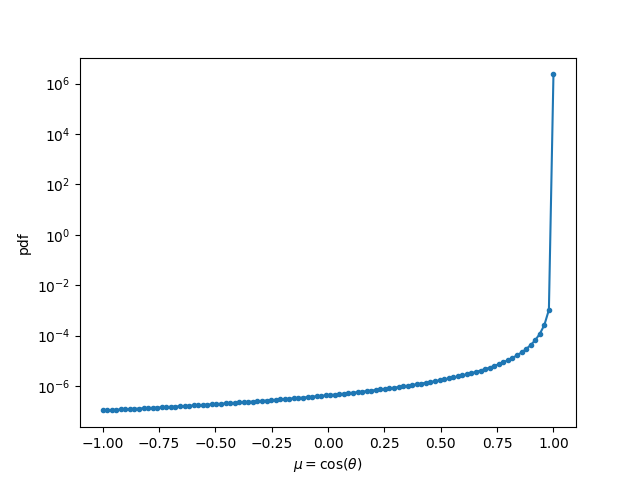

In [24]:
fig, ax = plt.subplots()
ax.semilogy(muRange, pdfs, '.-')
ax.set_xlabel('$\mu = \cos(\\theta)$')
ax.set_ylabel('pdf')

In [66]:
emin = 1e-3
emax = 21/ERE
eRange = np.logspace(math.log10(emin), math.log10(emax), 200)
Ecost = np.array([particle.getMeanMu(energy, WaterMaterial) for energy in eRange], dtype=float)

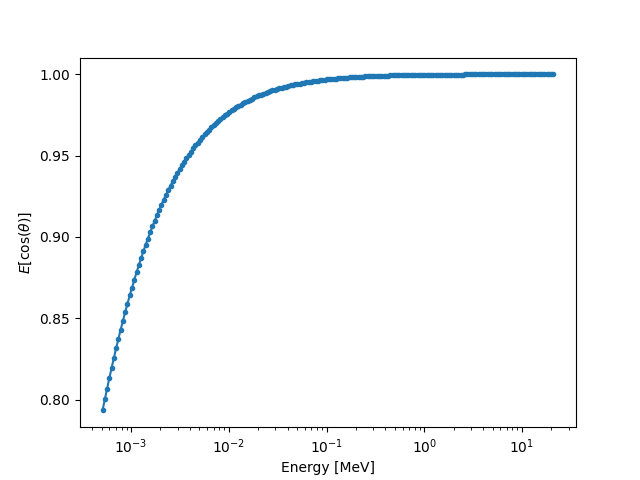

In [68]:
fig, ax = plt.subplots()
ax.semilogx(eRange*ERE, Ecost, '.-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('$E[\cos(\\theta)]$')
fig.savefig('figures/Ecost.pdf')

Second moment

In [27]:
exp = sy.integrate((mu**2)*pdf, (mu, -1, 1))
print(f'$E[cos(\\theta)^2]$: {sy.simplify(exp)}')
# Wolfram alpha result: 1 + 8 a (1 + a) - 4 a (1 + a) (1 + 2 a) log(1 + 1/a) (with a = eta)

$E[cos(\theta)^2]$: 8*eta**2 + 8*eta + log(eta**(8*eta**3 + 12*eta**2 + 4*eta)*(eta + 1)**(-8*eta**3 - 12*eta**2 - 4*eta)) + 1


In [28]:
Ecost2 = np.array([particle.getMuMoment2(energy, WaterMaterial) for energy in eRange], dtype=float) 

Text(0, 0.5, '$E[\\cos(\\theta)]^2$')

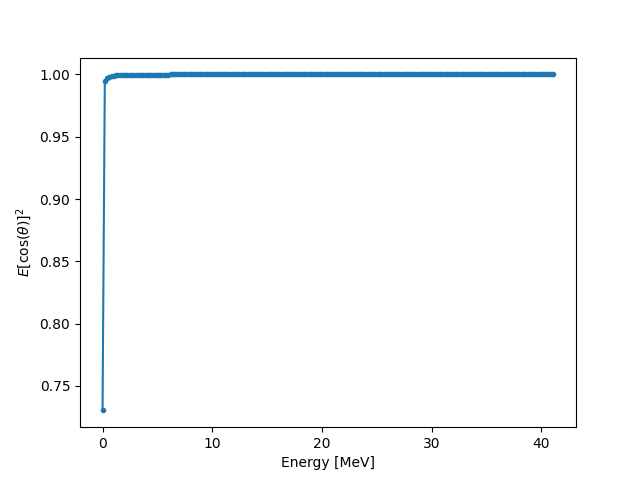

In [29]:
fig, ax = plt.subplots()
ax.plot(eRange, Ecost2, '.-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('$E[\cos(\\theta)]^2$')

Expectation of sin(theta)^2

In [30]:
sy.init_printing()
exp1 = sy.integrate((1 - mu**2)*pdf, (mu, -1, 1))
print(exp1)
print(f'E[sin(\\theta)^2]: {sy.simplify(exp1)}')
# Again weird expression from sympy. Use Wolfram alpha output instead.

-4*eta**2 - 4*eta*(eta + 1)*(2*eta + 1)*log(-2*eta) + 4*eta*(eta + 1)*(2*eta + 1)*log(-2*eta - 2) - 4*eta + (-8*eta**4 - 16*eta**3 - 8*eta**2)/(-2*eta - 2) + (-8*eta**4 - 16*eta**3 - 8*eta**2)/(2*eta)
E[sin(\theta)^2]: 4*eta*(-2*eta + log(eta**(-2*eta**2 - 3*eta - 1)*(eta + 1)**(2*eta**2 + 3*eta + 1)) - 2)


In [31]:
Esint2 = np.array([particle.getSintMoment2(energy, WaterMaterial) for energy in eRange], dtype=float) 

Text(0, 0.5, '$E[\\sin(\\theta)]^2$')

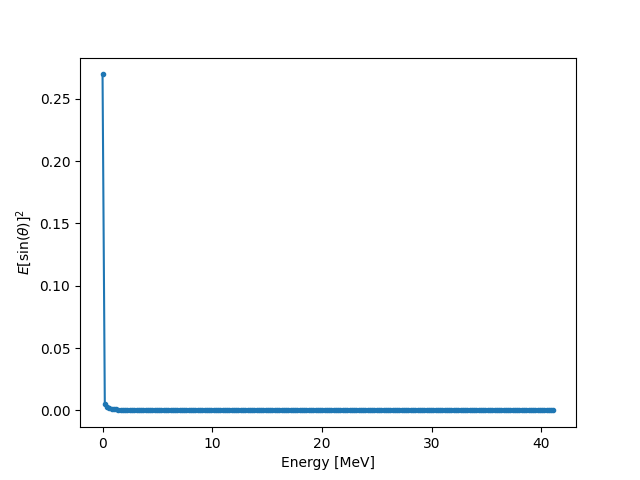

In [32]:
fig, ax = plt.subplots()
ax.plot(eRange, Esint2, '.-')
ax.set_xlabel('Energy [MeV]')
ax.set_ylabel('$E[\sin(\\theta)]^2$')

Step length of mean kinetic motion

In [33]:
def getMean(Sigma, Ecost, ds) -> float:
    return Ecost*(1 - math.exp(Sigma*ds*(Ecost-1)))/((1 - Ecost)*Sigma)


In [39]:
ds = 0.1
SigmaArray = np.logspace(0, 4, 100)
EcostArray = np.array((0.9, 0.95, 0.98, 0.999), dtype=float)

meandx = np.empty(shape=(SigmaArray.size, EcostArray.size), dtype=float)
for i, sigma in enumerate(SigmaArray):
    for j, ecost in enumerate(EcostArray):
        meandx[i, j] = getMean(sigma, ecost, ds)


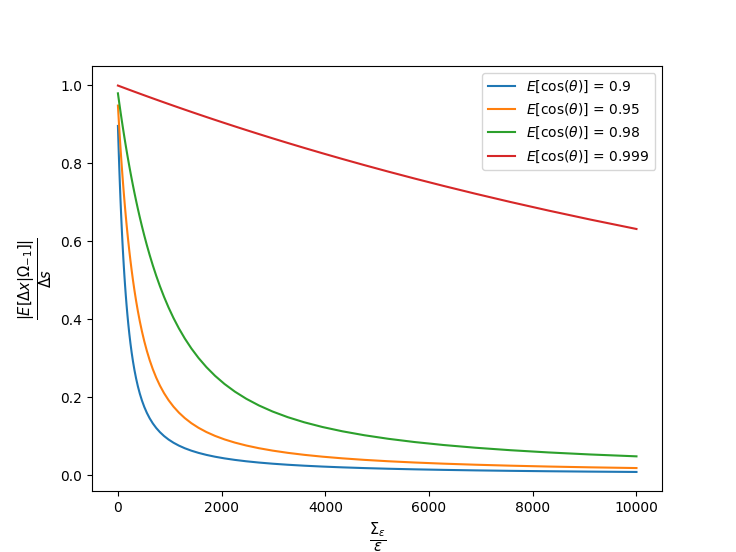

In [59]:
fontsize = 15
scalar = 1.15
width = 6.4*scalar
height = 4.8*scalar
fig, ax = plt.subplots(1, 1, figsize=(width, height))
for i, ecost in enumerate(EcostArray):
    ax.plot(SigmaArray, meandx[:, i]/ds, label=f'$E[\cos(\\theta)]$ = {ecost}')
ax.legend()
ax.set_xlabel('$\\frac{\Sigma_{\epsilon}}{\epsilon}$', fontsize=fontsize)
ax.set_ylabel('$\\frac{|E[\Delta x | \Omega_{-1}]|}{\Delta s}$', fontsize=fontsize)
fig.savefig('figures/theoreticalMeanKineticMotion.pdf')